# Decitabine treatment RNA-Seq experiments
- ### [Pre-processing](#Pre-processing)
- ### [Differential expression analysis using `DESeq2`](#Differential-expression-analysis-using-DESeq2)
  - #### [Decitabine treatment time-series RNA-Seq experiments in HL60 cell line](#Decitabine-treatment-time-series-RNA-Seq-experiments-in-HL60-cell-line)
  - #### [Decitabine treatment RNA-Seq experiments in 5 other AML cell lines](#Decitabine-treatment-RNA-Seq-experiments-in-5-other-AML-cell-lines)

# Pre-processing 

I'm mapping `hg38/gencode.v34` to the `fastq` files using salmon. 

In [3]:
cat scripts/salmon.sh

JOBDIR=$1
FASTQDIR=$2
INDEX=$3

cd $JOBDIR
mkdir -p ./quants/

for f in $FASTQDIR/*fastq.gz; do 
	samp=`basename ${f}`; 
	samp=${samp/.fastq.gz/}; 
	echo "Processing sample ${samp}"; 
	salmon quant -i $INDEX \
 	-l A -r $f -p 18 --validateMappings -o ./quants/$samp; 
done


In [1]:
# %%bash 
# nohup bash scripts/salmon.sh \
# ~/Gilbertlab/Decitabine_treatment/RNA-seq/hl60-exp \
# ~/Gilbertlab/Decitabine_treatment/RNA-seq/hl60-fastq \
# ~/genomes/hg38/gencode.v34/salmon_index/ > hl60-salmon.out&

# Differential expression analysis using `DESeq2`

## Load packages, functions and main data

In [2]:
# %load_ext rpy2.ipython

In [1]:
# %%R 
suppressMessages(suppressWarnings(library (GenomicFeatures)))
suppressMessages(suppressWarnings(library (tximport)))
suppressMessages(suppressWarnings(library (tidyverse)))
suppressMessages(suppressWarnings(library (ggplot2)))
suppressMessages(suppressWarnings(library (ggrepel)))
suppressMessages(suppressWarnings(library (DESeq2)))
suppressMessages(suppressWarnings(library (patchwork)))
suppressMessages(suppressWarnings(library (BiocParallel)))
suppressMessages(suppressWarnings(library (gridExtra)))
library(grid)

register(MulticoreParam(18))

In [2]:
source('../util.R')

In [3]:
# Filter non-informative genes:
filter_low_counts <- function (dds_in , min_count=10){
    # all samples with a count of higher than `min_count`
    keep <- rowSums(counts(dds_in ) > min_count) == ncol(dds_in )
    dds_out <- dds_in [keep,]
    print (paste (nrow(dds_in), 'genes filtered to ->' , nrow(dds_out),'genes!', sep=' ') )
    return (dds_out)
}


plot_PCA <- function(vsd, colData, labels='', gr=c('cond'), title='', leg="none"){
    z <- plotPCA(vsd,intgroup=gr, returnData=TRUE)
    percentVar <- round(100 * attr(z, "percentVar"))
    pca <- ggplot(z, aes(PC1, PC2)) +
            geom_point(aes(colour=group), alpha = 4/10,size=12) + 
            geom_point(shape = 1,size = 12,colour = "black") + 
            # geom_point(
            #     aes(color=group), 
            #     
            # size=10,
            # stroke = 0.5
            # ) +
            geom_text_repel(
                aes(label = labels),
                box.padding = 1.5, max.overlaps = Inf
            ) + #,size = 3.5)) +
            xlab(paste0("PC1: ",percentVar[1],"% variance")) +
            ylab(paste0("PC2: ",percentVar[2],"% variance")) +
            ggtitle (title) + 
            scale_colour_Publication() + 
            theme_Publication(legend.position='top') +
            guides (size = 'none') + theme(legend.title = element_blank()) 
    return (pca)
}

In [4]:
write_Result <- function(res, name_it, col=FALSE, row=FALSE){
    write.table(res,name_it, sep="\t", quote=FALSE, col.names=col, row.names=row)
}


correct_batch <- function (dds,gr,out,labels='',title=''){
    vsd <- varianceStabilizingTransformation(dds, blind=FALSE)
    p0 <- plot_PCA(vsd, gr, labels=labels,title=paste0(title,' Before removeBatchEffect'))
    mat <- assay(vsd)
    
    mat <- limma::removeBatchEffect(mat, vsd$reps) # batch is same as time 
    assay(vsd) <- mat
    p1 <- plot_PCA(vsd, gr, labels=labels,title=paste0(title,' After removeBatchEffect'))
    counts_batch_corrected <- assay(vsd)
    
    if (out == 'plot') {return (p0 + p1)}
    if (out == 'plot1'){return (p1)}
    if (out == 'vsd')  {return (vsd)}
    if (out == 'cbc')  {return (counts_batch_corrected)}
}


ann_Result <- function(res){
    return (
        res %>% data.frame %>% 
        add_column(gene_name=gene2name[rownames(res),]) %>%
        add_column(gene_id=rownames(res)) %>% 
        select (gene_id,gene_name,everything())
    )
}

plot_gene_counts <- function (dds, gene_id,gene_name){
    fiss <- plotCounts(dds, gene_id, intgroup = c("cond"), returnData = TRUE)

    p <- ggplot(fiss,
      aes(x = cond, y = count, color = cond)) + 
      geom_point(size=5,alpha=8/10) + stat_summary(fun=mean, geom="line") +
      scale_y_log10() + 
      theme_bw() + 
      ggtitle(gene_name)
    
    return (p + theme_Publication())
}

Load annotations

In [5]:
# %%R
GTF = '~/genomes/hg38/gencode.v34/gencode.v34.annotation.gtf'
gtf <- rtracklayer::import(GTF)
gene2name <- gtf[gtf$type == "gene"] %>% data.frame %>% column_to_rownames('gene_id') %>% dplyr::select('gene_name')

txdb  = makeTxDbFromGFF(GTF,organism='Homo sapiens')
# tx2gene objects 
k <- keys(txdb, keytype = "TXNAME")
tx2gene <- AnnotationDbi::select(txdb, k, "GENEID", "TXNAME")

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”
OK

'select()' returned 1:1 mapping between keys and columns



In [6]:
# %%R 
tx2name <- gtf[gtf$type == "transcript"] %>% data.frame %>% column_to_rownames('transcript_id') %>% dplyr::select('transcript_name')

## General analysis

List every salmon quant files

In [7]:
# %%R
files <- list.files(path='./quants', pattern="quant.sf",full.names = TRUE, recursive=T)
names(files) <- gsub("./quants/(\\S+)/quant.sf","\\1",files)

In [8]:
txi <- tximport(files, type = "salmon", tx2gene = tx2gene, txOut=TRUE)

txi.gene <- summarizeToGene(txi, tx2gene, ignoreAfterBar= TRUE)

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 
36 
37 
38 
39 
40 
41 
42 


summarizing abundance

summarizing counts

summarizing length



In [9]:
# names(files)

#### Define sample sheet

In [10]:
# meta 
lines   <- c(rep('hl60',12),lapply(c('kg1', 'molm14', 'ociaml2', 'ociaml3', 'thp1'), rep, 6) %>% unlist)

# meta 
conds  <- factor(c(
    # hl60
    rep(c(rep('Decitabine',2),rep('DMSO',2)),3),
    # 5 other cell lines
    rep(c(rep('Decitabine',3), rep('DMSO',3)),5)
), levels = c('DMSO','Decitabine'))

reps <- factor(c(
    # hl60
    rep(c('rep1','rep2'),6),
    # 5 other cell lines
    rep(c('rep1','rep2','rep3'),10)
),c('rep1','rep2','rep3'))

hours <- factor(c(
    # hl60
    c(rep('120h',4),rep('6h',4),rep('72h',4)), 
    # 5 other cell lines
    rep('72h',30)
),c('6h','72h','120h') )

colData <- data.frame(
    line=lines, 
    cond=conds,
    time=hours,
    reps=reps,
    row.names=colnames(txi$abundance),
    stringsAsFactors=FALSE
)
colData

,line,cond,time,reps
,<chr>,<fct>,<fct>,<fct>
hl60_120h_t_1,hl60,Decitabine,120h,rep1
hl60_120h_t_2,hl60,Decitabine,120h,rep2
hl60_120h_u_1,hl60,DMSO,120h,rep1
hl60_120h_u_2,hl60,DMSO,120h,rep2
hl60_6h_t_1,hl60,Decitabine,6h,rep1
hl60_6h_t_2,hl60,Decitabine,6h,rep2
hl60_6h_u_1,hl60,DMSO,6h,rep1
hl60_6h_u_2,hl60,DMSO,6h,rep2
hl60_72h_t_1,hl60,Decitabine,72h,rep1


#### Save normalized counts

In [11]:
dds <- DESeqDataSetFromTximport(txi.gene, colData, ~cond)

using counts and average transcript lengths from tximport



In [12]:
dds <- estimateSizeFactors(dds)

ncu <- counts(dds, normalized=TRUE) 

using 'avgTxLength' from assays(dds), correcting for library size



In [13]:
ncu %>% data.frame %>% 
    add_column(name = gene2name[rownames(ncu),]) %>% 
    select(name, everything()) -> ncu

In [16]:
write.table(
    ncu,'exp/deseq2_norm.txt', sep="\t", quote=FALSE, col.names=TRUE
)

___
## Decitabine treatment time-series RNA-Seq experiments in HL60 cell line

In order to test for any differences over multiple time points, once can use a design including the time factor, and then test using the **likelihood ratio test (LRT)**. Here, as we have control (DMSO) and treatment (Decitabine) time series, design formula containing the condition factor, the time factor, and the interaction of the two. In this case, using the likelihood ratio test with a reduced model which does not contain the interaction terms will test whether the condition induces a change in gene expression at any time point after the reference level time point (time 0). 

(see [this](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#time-series-experiments)  OR [this](http://master.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#time-course-experiments) for more details about DESeq2 time series experiments)

### Load count data and meta table 

Import salmon quants

In [14]:
txi_hl60 <- tximport(
    files[grep("hl60", files, fixed=T)], 
    type = "salmon", tx2gene = tx2gene, txOut=TRUE
)

txi_hl60.gene <- summarizeToGene(txi_hl60, tx2gene, ignoreAfterBar= TRUE)

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 


summarizing abundance

summarizing counts

summarizing length



Define the sample sheet

In [16]:
colData[colData$line == 'hl60',]

,line,cond,time,reps
,<chr>,<fct>,<fct>,<fct>
hl60_120h_t_1,hl60,Decitabine,120h,rep1
hl60_120h_t_2,hl60,Decitabine,120h,rep2
hl60_120h_u_1,hl60,DMSO,120h,rep1
hl60_120h_u_2,hl60,DMSO,120h,rep2
hl60_6h_t_1,hl60,Decitabine,6h,rep1
hl60_6h_t_2,hl60,Decitabine,6h,rep2
hl60_6h_u_1,hl60,DMSO,6h,rep1
hl60_6h_u_2,hl60,DMSO,6h,rep2
hl60_72h_t_1,hl60,Decitabine,72h,rep1


### PCA
<!-- Initial principal component analysis (PCA) shows the second treated biological replicate at 72h time point, behaves as an outlier. Removing that from the analysis give us a better representation of our dataset. In the second PCA plot, we can see that treated samples at 6h cluster with the non-treated samples which suggest that 6 hours treatment with the drug is not as effective as 72h and 120h. Although, we will check the variant genes in this time-point in the following statistical analysis. -->


In [19]:
dds0 <- DESeqDataSetFromTximport(txi_hl60.gene, colData[colData$line == 'hl60',], ~0 + cond + time )
nrow(dds0)

using counts and average transcript lengths from tximport



[1] 60240

In [20]:
dds.pca <- DESeq(dds0, parallel=TRUE)
# results 
vsd_hl60 <- varianceStabilizingTransformation(dds.pca)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates: 18 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 18 workers



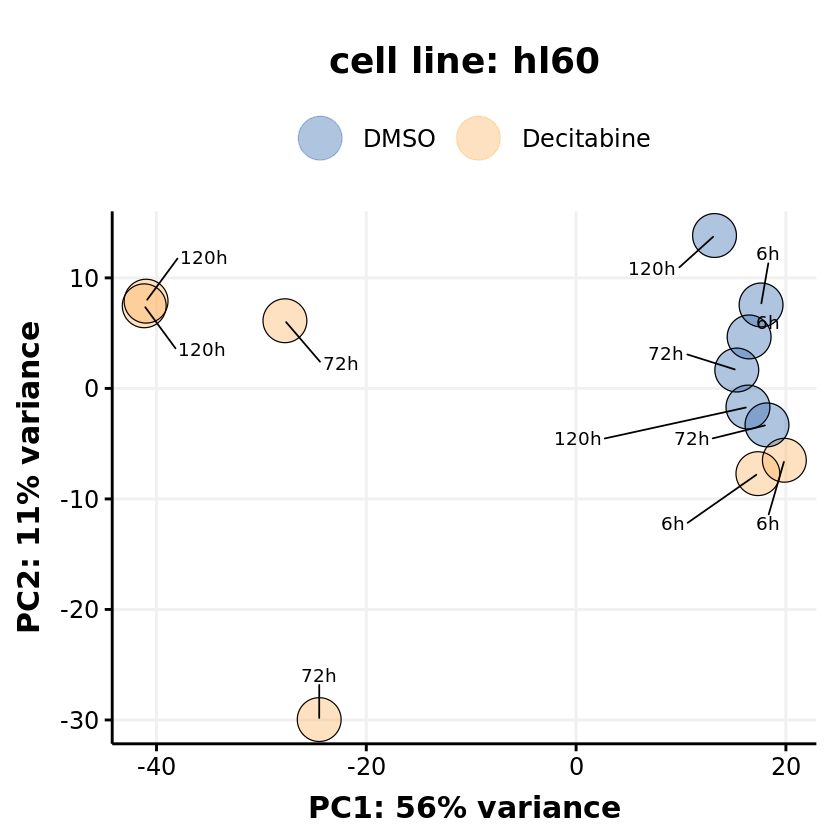

In [21]:
pca_hl60 <- plot_PCA(
    vsd_hl60, 
    colData(vsd_hl60), 
    labels=colData(vsd_hl60)[,'time'],gr=c('cond'), title='cell line: hl60'
)

ggsave('exp/plots/pca_hl60.pdf',pca_hl60,width=5,height=5.5)
pca_hl60

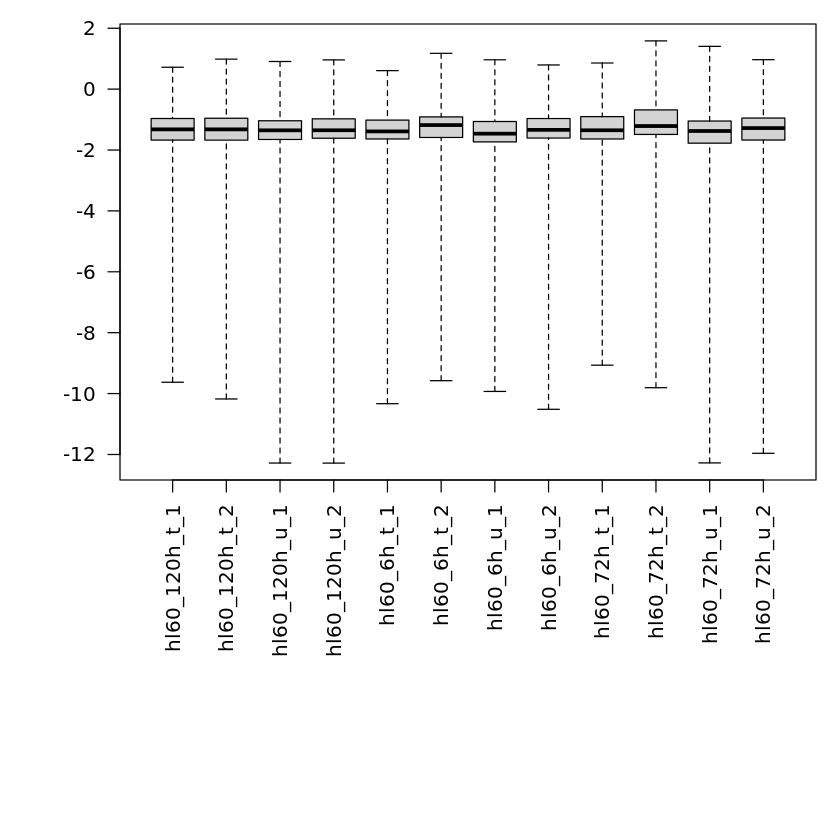

In [22]:
par(mar=c(15,5,1,1))
boxplot(log10(assays(dds.pca)[["cooks"]]), range=0, las=2)

###
<!-- ### Filter non-informative genes  -->
<!-- and outlier sample: -->

In [23]:
# # %%R 
# # all samples with a count of higher than 10
# keep <- rowSums(counts(dds0) > 10) == ncol(dds0)
# # at least 3 samples with a count of 10 or higher
# # keep <- rowSums(counts(dds) >= 10) >= 3

# dds1 <- dds0[keep,-12]
# dds1 <- DESeq(dds1) #, parallel=TRUE)
# nrow(dds1)

In [24]:
# # %%R
# # results 
# vsd <- varianceStabilizingTransformation(dds1)
# pca_hl60_filtered = plot_PCA(
#     vsd, colData[-12,], labels= colData[-12,'time'],
#     title='cell line: hl60')#Remove sample 72h_u_2')

Create seprate PCAs

In [25]:
# # %%R 
# dds2 <- DESeqDataSetFromTximport(txi_hl60, colData, ~time)

# U = grep('_u_', colnames(dds2), value=1) # DMSO
# T = grep('_t_', colnames(dds2), value=1)[-6] # Decitabine

# # subset
# dds.U = dds2[keep, U]
# # make object for the PCA
# dds.pcaU <- DESeq(dds.U) #, parallel=TRUE)
# vsd.U <- varianceStabilizingTransformation(dds.pcaU)

# # subset
# dds.T = dds2[keep, T]
# # make object for the PCA
# dds.pcaT <- DESeq(dds.T) #, parallel=TRUE)
# vsd.T <- varianceStabilizingTransformation(dds.pcaT)

In [26]:
# # plot it 
# pca_hl60_U = plot_PCA(
#     vsd.U, colData[U,], labels= colData[U,'time'],
#     gr=c('time'), title='Non-treated'
# )
# pca_hl60_T = plot_PCA(
#     vsd.T, colData[T,], labels= colData[T,'time'],
#     gr=c('time'), title='Treated'
# )

In [27]:
# pca_hl60

In [28]:
# pca_hl60_filtered / (pca_hl60_U + pca_hl60_T)

### Differential expression analysis
I'm doing differential expression analysis for treated samples vs. untreated at 6h, 72h and 120h. 

#### First scenario
Time included as factor variable. 

We make two different `dds` object one with with no `cond:time` interaction term and the other one with the interaction term (**ANOVA-like comparison**). 

<!-- Then, I'm replacing results from first object to the secound one for genes with adjust p-values (padj) > 0.05. Hossien Asgharian told me these genes has more accurate estimation from the model with no interaction term.  -->

https://bioconductor.org/packages/release/workflows/vignettes/RNAseq123/inst/doc/designmatrices.html#design-matrices-with-and-without-intercept-term

In [17]:
levels(colData$cond)

[1] "DMSO"       "Decitabine"

In [18]:
model.matrix(~0+cond*time, colData[colData$line=='hl60',])

,condDMSO,condDecitabine,time72h,time120h,condDecitabine:time72h,condDecitabine:time120h
hl60_120h_t_1,0,1,0,1,0,1
hl60_120h_t_2,0,1,0,1,0,1
hl60_120h_u_1,1,0,0,1,0,0
hl60_120h_u_2,1,0,0,1,0,0
hl60_6h_t_1,0,1,0,0,0,0
hl60_6h_t_2,0,1,0,0,0,0
hl60_6h_u_1,1,0,0,0,0,0
hl60_6h_u_2,1,0,0,0,0,0
hl60_72h_t_1,0,1,1,0,1,0
hl60_72h_t_2,0,1,1,0,1,0


In [19]:
dds <- DESeqDataSetFromTximport(txi_hl60.gene, colData[colData$line=='hl60',], ~0 + cond + time + cond:time)

# Annova test
dds <- DESeq(dds, test="LRT", reduced=~1, parallel=TRUE)

using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates: 18 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 18 workers



In [20]:
resultsNames(dds)

[1] "condDMSO"                "condDecitabine"         
[3] "time72h"                 "time120h"               
[5] "condDecitabine.time72h"  "condDecitabine.time120h"

In [33]:
# saveRDS(dds,'dds.rds.gz',compress='gzip')

In [34]:
# dds_ind <- DESeqDataSetFromTximport(txi.gene, colData, ~0+cond + time)

# dds_ind$time <- relevel(dds_ind$time, ref="6h")
# dds_ind$cond <- relevel(dds_ind$cond, ref="DMSO")


# dds_ind <- DESeq(dds_ind, test="LRT", reduced=~1) #, parallel=TRUE)

# resultsNames(dds_ind)

# # no interaction
# res.ind = results(dds_ind,contrast=list("condDMSO","condDecitabine"),listValues=c(1,-1)) %>% ann_Result

In [22]:
# contrast design: treatment at 6h vs dmso at 6h
res.6h  = results(dds, contrast=list("condDecitabine","condDMSO"),listValues=c(1,-1)) %>% ann_Result

# contrast design: treatment at 72h vs dmso at 72h
res.72h = results(dds, contrast=list(c('condDecitabine', 'condDecitabine.time72h'),c('condDMSO')),listValues=c(1,-1)) %>% ann_Result

# contrast design: treatment at 120h vs dmso at 120h
res.120h = results(dds, contrast=list(c('condDecitabine', 'condDecitabine.time120h'),c('condDMSO')),listValues=c(1,-1)) %>% ann_Result

In [24]:
res.6h$pvalue %>% head 

[1] 3.256654e-01           NA 4.291700e-06 8.537790e-01 1.669193e-01
[6] 1.778575e-29

In [25]:
res.72h$pvalue %>% head 

[1] 3.256654e-01           NA 4.291700e-06 8.537790e-01 1.669193e-01
[6] 1.778575e-29

#### Check the direction of logFC 

In [36]:
# head(df_sig)

In [37]:
# plot_Volcano(
#     res.120h, 
#     title='Treatment time: 120 hours',
#     labels=10
# )

In [38]:
# plot_gene_counts(dds,  'ENSG00000121053.6','EPX')

#### Second scenario
Time as continues variable

In [39]:
# %%R 
# # meta 
# colData.T <- data.frame(
#     time=c(rep(120,4),rep(6,4),rep(72,4)), 
#     cond=rep(c(rep('DMSO',2), rep('Decitabine',2)),3), 
#     time_cond=paste(hours,treats,sep='_'), 
#     sample_id=colnames(txi$abundance),
#     row.names=colnames(txi$abundance))

# dds.T <- DESeqDataSetFromTximport(txi.gene, colData.T, ~cond + time + cond:time)
# dds.T <- DESeq(dds.T, test="LRT", reduced=~1, parallel=TRUE)

In [40]:
# %%R
# resultsNames(dds.T)

In [41]:
# %%R
# res_cnt_time_T_vs_U = results(dds.T, name='cond_Decitabine_vs_DMSO', parallel=T) %>% 
#     data.frame %>% add_column(name = gene2name[rownames(dds.T),]) %>%
#     add_column(ensembl = rownames(dds.T) %>% substr(0, 15))

# p1 = plot_Volcano(res_cnt_time_T_vs_U, 0.1, title='Time as continuous variable: Treated vs DMSO', 
#                   x_min=-2,x_max=2)

In [42]:
# %%R
# res_cnt_time = results(dds.T, name='condDecitabine.time', parallel=T) %>% 
#     data.frame %>% add_column(name = gene2name[rownames(dds.T),]) %>%
#     add_column(ensembl = rownames(dds.T) %>% substr(0, 15))

# p2 = plot_Volcano(res_cnt_time, 0.01, title='Time as continuous variable: Condition and time interaction', 
#                   x_min=-0.1,x_max=0.1)

In [43]:
# %%R
# df = data.frame(
#     'gene_id'=rownames(res_cnt_time_T_vs_U), 'gene_name'= res_cnt_time_T_vs_U$name,
#     'baseMean' = res_cnt_time$baseMean,
#     'log2FC_time' = res_cnt_time$log2FoldChange,'log2FC_time'= res_cnt_time$pval,
#     'log2FC_T_vs_U' = res_cnt_time_T_vs_U$log2FoldChange,'pval_T_vs_U'= res_cnt_time_T_vs_U$pval
# )    
# df = df[order(df$log2FC_time),]

# write_Result(df, 'results_time_continuous.txt', col=TRUE)

In [44]:
# %%R
# plot_Save(p1 / p2, 'Volcano_time_continuous')
# p1 / p2

#### Find transcripts of genes selected for experimental validation 
Hani: 
> can you tell me for the selected genes, which isoforms are the major isoforms?

In [45]:
# %%R 
# valid_genes = gene2name %>% rownames_to_column('GENEID') %>% filter(gene_name%in%c('MTF1', 'MCL1', 'INTS5', 'SQLE'))

# valid_txs = tx2gene %>% filter(GENEID%in%valid_genes$GENEID)

# dds_txi <- DESeqDataSetFromTximport(txi, colData, ~0 + cond + time + cond:time)
# nrow(dds_txi)

In [46]:
# %%R -o valid_df

# counts(dds_txi[valid_txs$TXNAME,], normalized=FALSE) %>% 
#     data.frame %>% 
#     rownames_to_column('transcript_id') -> valid_df
# valid_df %>% 
#     add_column(name=tx2name[valid_df$transcript_id,]) %>% 
#     arrange(desc(X72h_DMSO_rep1)) -> valid_df

In [47]:
# valid_df.set_index('transcript_id').loc[
#     list (valid_df.loc[:,['X72h_DMSO_rep1','X72h_DMSO_rep2','X72h_Decitabine_rep1','X72h_Decitabine_rep2']].min(axis=1) > 80),
#     ['name','X72h_DMSO_rep1','X72h_DMSO_rep2','X72h_Decitabine_rep1','X72h_Decitabine_rep2']
# ]

In [48]:
# %%R 
# dds_txi$time <- relevel(dds_txi$time, ref="6h")

# # Annova test
# dds_txi <- DESeq(dds_txi, test="LRT", reduced=~1) #, parallel=TRUE)
# ncu_txi <- counts(dds_txi, normalized=TRUE) 
# # write.table(ncu,'hl60_exp_deseq2_norm.txt', sep="\t", quote=FALSE, col.names=colData$sample_id)

In [49]:
# %%R
# resultsNames(dds_txi)

In [50]:
# %%R 
# saveRDS(dds_txi,'dds_txi.rds.gz',compress='gzip')

In [51]:
# %%R 
# dds_valid_txs = dds_txi[valid_txs$TXNAME,]

Check logFC direction (expected: down expression) 

In [52]:
# %%R 
# p1 = plot_gene_counts(
#     dds_txi,  'ENST00000265896.10', 'ENST00000265896.10\nSQLE-201'
# ) / plot_gene_counts(
#     dds_txi,  'ENST00000330574.2','ENST00000330574.2,INTS5-201'
# )

# plot_Save(p1,'plots/counts_targets_dn.pdf')
# p1

Check logFC direction (expected: up expression) 

In [53]:
# %%R 
# p2 = plot_gene_counts(
#     dds_txi,  'ENST00000369026.3','ENST00000369026.3\nMCL1-202'
# ) / plot_gene_counts(
#     dds_txi,  'ENST00000373036.5','ENST00000373036.5\nMTF1-201'
# )

# plot_Save(p2,'plots/counts_targets_up.pdf')

# p2

In [54]:
# %%R 
# tx2name %>% rownames_to_column('transcript_id') %>% filter(transcript_id %in% rownames(dds_valid_txs) )


In [55]:
# %%R 
# get_Result_txi <- function(dds, design){
#     res = results(dds, contrast=design, parallel=TRUE)  %>%
#         data.frame %>% 
#         add_column(name=tx2name[rownames(dds),])
                
#     return (res)
# }

# # contrast design: treatment at 72h vs dmso at 72h
# res_txi.72h = get_Result_txi(dds_txi, list('cond_treated_vs_DMSO', 'condtreated.time72h')) 
# res_valid_txi.72h = get_Result_txi(dds_valid_txs, list('cond_treated_vs_DMSO', 'condtreated.time72h')) 

# # # contrast design: treatment at 6h vs dmso at 6h
# # res.6h  = get_Result(dds_txi, list('cond_treated_vs_DMSO'))
# # # contrast design: treatment at 120h vs dmso at 120h
# # res.120h= get_Result(dds, list('cond_treated_vs_DMSO', 'condtreated.time120h'))

In [56]:
# %%R 

# lfc.cutoff  = 0; pval.cutoff = 1; 
# title='Treated time: 72 hours'; 
# x_min=-20;x_max=20;y_max=4
# res = res_valid_txi.72h

# res$sig <- as.factor(res$pvalue < pval.cutoff & abs(res$log2FoldChange) > lfc.cutoff)
# res$sig <- relevel(res$sig, ref=TRUE)

# vol = res %>% ggplot(
#     aes(x=log2FoldChange, y=-log10(pvalue), colour=sig, fill=sig)) +
#     geom_point(aes(color = sig),alpha = 1/10) +
#     xlim(c(x_min,x_max)) +
#     ylim(c(0,y_max)) +
#         geom_hline(yintercept=-log10(pval.cutoff), linetype="dashed", alpha = 4/10) +
#         geom_vline(xintercept=lfc.cutoff, linetype="dashed", alpha = 4/10) +
#         geom_vline(xintercept=(-1)*lfc.cutoff, linetype="dashed", alpha = 4/10) +
#         scale_color_manual(values = c("grey", "red")) +
#         theme_bw() + 
#         theme(legend.position="none") +
#         ggtitle (title) + 
#         geom_text_repel(
#             data = subset(res[order(res$pvalue),], sig == TRUE),#[1:10,],
#             aes(label = name),
#             size = 2,
#             box.padding = unit(0.35, "lines"),
#             point.padding = unit(0.3, "lines")
#         )
# plot_Save(vol, 'plots/Volcano_plot_validation_genes')
# vol


In [57]:
# %%R 


# gene_names = levels(droplevels(head(df_sig$gene_name)))
# gene_ids = rownames(gene2name)[gene2name$gene_name %in% gene_names]


# plot_gene_counts(dds,  gene_ids[4],gene_names[4]) /
# plot_gene_counts(dds,  gene_ids[5],gene_names[5])

#### 72 hour only comparison 

In [58]:
txi_hl60_72h <- tximport(
    files[grep("hl60_72h", files, fixed=T)], 
    type = "salmon", tx2gene = tx2gene, txOut=TRUE
)

txi_hl60_72h.gene <- summarizeToGene(txi_hl60_72h, tx2gene, ignoreAfterBar= TRUE)

reading in files with read_tsv

1 
2 
3 
4 


summarizing abundance

summarizing counts

summarizing length



Define the sample sheet

In [59]:
dds72h <- DESeqDataSetFromTximport(txi_hl60_72h.gene, colData[colData$time == '72h' & colData$line =='hl60',], ~cond)

dds72h <- DESeq(dds72h)

using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [60]:
res.72h.only <- results(dds72h,name='cond_Decitabine_vs_DMSO') %>% 
data.frame %>% ann_Result

In [61]:
# plot_Volcano(res.72h.only,labels=10)

### Save results into a list

In [62]:
RES = list(res.6h,res.72h,res.72h.only,res.120h) 
names(RES) <- c('hl60_6h','hl60_72h','hl60_72h_only','hl60_120h') 

___
## Decitabine treatment RNA-Seq experiments in 5 other AML cell lines 

Here, I'll run basic DESeq2 analysis 

### Load count data and meta table 

Import salmon quants

In [63]:
txi_other <- tximport(
    files[grep("hl60", files, fixed=T,invert=TRUE)],
    type = "salmon", tx2gene = tx2gene, txOut=TRUE
)

txi_other.gene <- summarizeToGene(txi_other, tx2gene, ignoreAfterBar= TRUE)


reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 


summarizing abundance

summarizing counts

summarizing length



### PCA

In [64]:
# dds1 <- DESeq(dds0, parallel=TRUE)
# # results 
# vsd1 <- varianceStabilizingTransformation(dds1)

In [65]:
# pca  <- plot_PCA(vsd1, colData, gr=c('line'), leg='right')

In [66]:
# pca

Create seprate `dds` object for each cell line to do stable PCAs. 

In [67]:
rm(dds1)

dds1 <- DESeqDataSetFromTximport(txi_other.gene, colData[colData$line != 'hl60',], ~cond)

DDS0 = list()
DDS1 = list()
VSD = list()

# for loop to split DESeq object for more stable analysis  
for (l in unique(colData(dds1)$line) ){
    print (l)
    k = colData(dds1)$line == l
    # dds object for each cell line 
    DDS0[[l]] <- dds1[,c(k)]
    DDS1[[l]] <- DESeq(DDS0[[l]]) #, parallel=TRUE)
    VSD[[l]] <- varianceStabilizingTransformation(DDS0[[l]])
}

Warning message in rm(dds1):
“object 'dds1' not found”
using counts and average transcript lengths from tximport



[1] "kg1"


estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

using 'avgTxLength' from assays(dds), correcting for library size



[1] "molm14"


estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

using 'avgTxLength' from assays(dds), correcting for library size



[1] "ociaml2"


estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

using 'avgTxLength' from assays(dds), correcting for library size



[1] "ociaml3"


estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

using 'avgTxLength' from assays(dds), correcting for library size



[1] "thp1"


estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

using 'avgTxLength' from assays(dds), correcting for library size



In [68]:
# par(mar=c(15,5,1,1))
# boxplot(log10(assays(dds1)[["cooks"]]), range=0, las=2)

In [69]:
get_rep_id <- function(df,n=1){
    lapply(rownames(df), function(x){return(substring(x,nchar(x)-n+1))})
}

#### `kg1` PCA analysis 

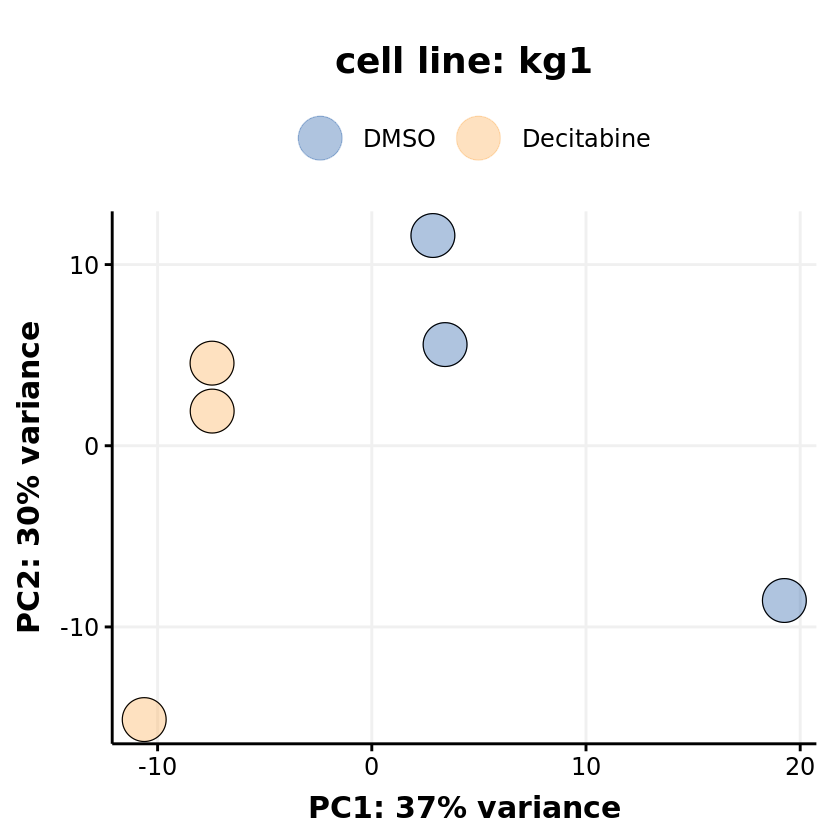

In [70]:
v = VSD[["kg1"]]
pca_kg1 <- plot_PCA(
    v, 
    colData(v),
    # labels = get_rep_id(colData(v)),
    title = 'cell line: kg1'
)

ggsave('exp/plots/pca_kg1.pdf',pca_kg1,width=6, height=6.8)
pca_kg1

#### `molm14` PCA analysis 

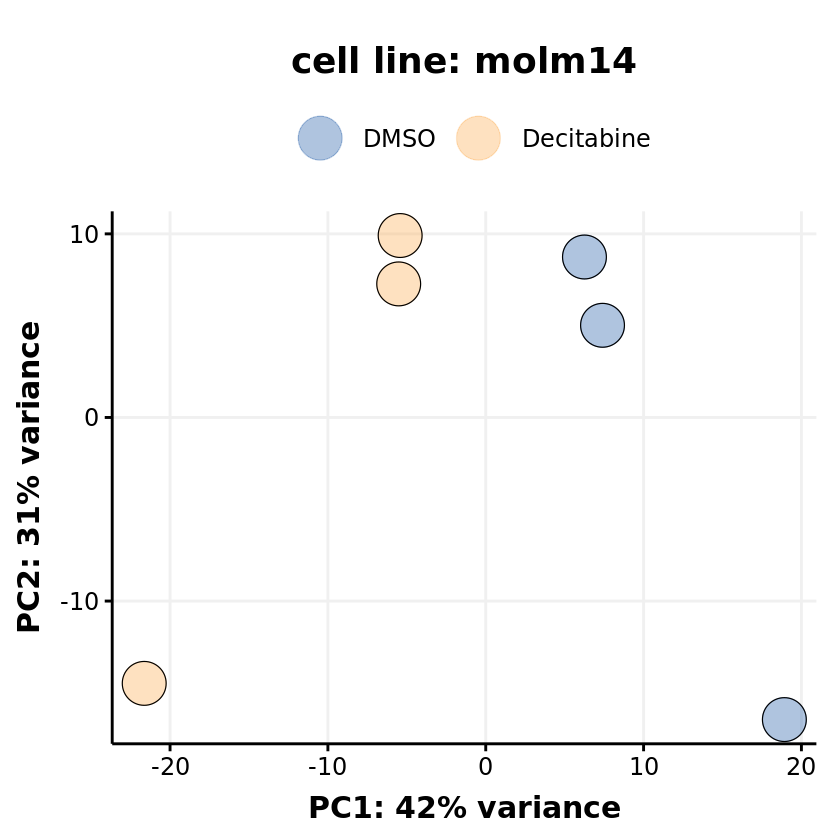

In [71]:
v = VSD[["molm14"]]
pca_molm14 <- plot_PCA(
    v, 
    colData(v),
    # labels = get_rep_id(colData(v)),
    title = 'cell line: molm14'
)

ggsave('exp/plots/pca_molm14.pdf',pca_molm14,width=6, height=6.8)

pca_molm14

#### `thp1` PCA analysis 

[1] "60240 genes filtered to -> 11297 genes!"


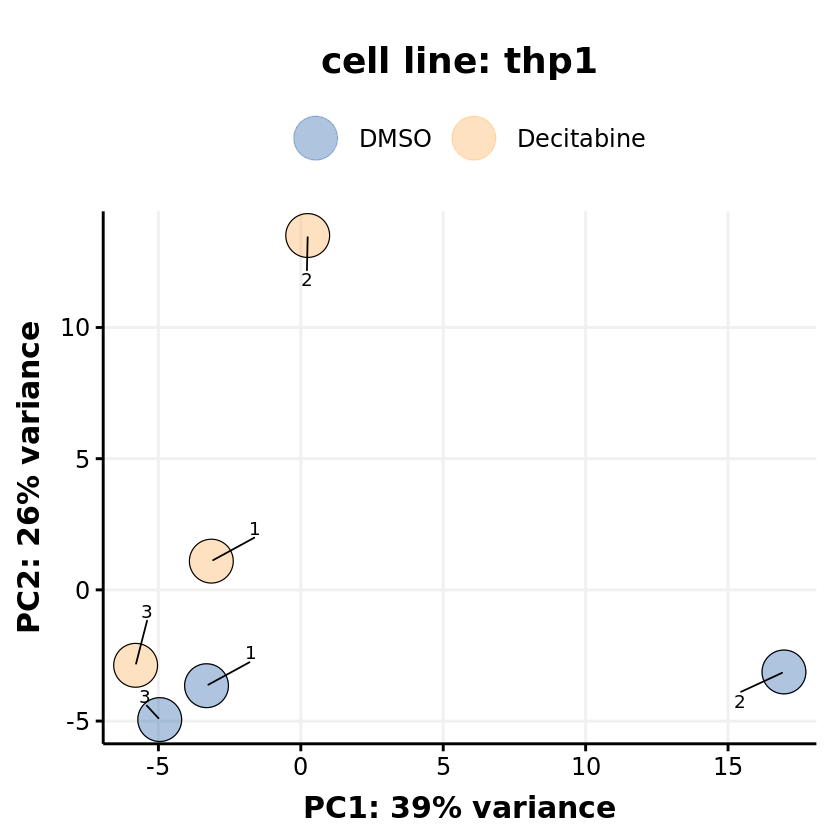

In [72]:
# v = VSD[["thp1"]]
v = DDS1[["thp1"]] %>% filter_low_counts(min_count=10) %>% varianceStabilizingTransformation

pca_thp1 <- plot_PCA(
    v,
    colData(v),
    labels = get_rep_id(colData(v)),
    title = 'cell line: thp1'
) 

# ggsave('exp/plots/pca_thp1.pdf',pca_thp1,width=6, height=6.8)

pca_thp1

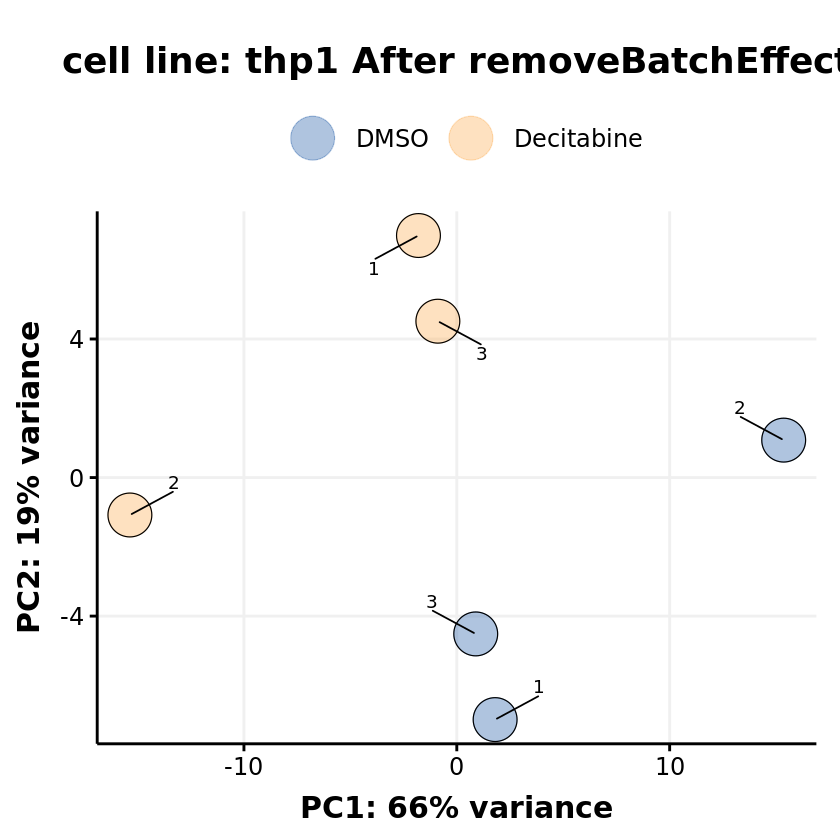

In [73]:
pca_thp1_corrected <- correct_batch(
    DDS1[['thp1']],c('cond'),'plot1',title='cell line: thp1',
    labels=get_rep_id(colData(DDS0[['thp1']]))
)

ggsave('exp/plots/pca_thp1_corrected.pdf',pca_thp1_corrected,width=6, height=6.8)

pca_thp1_corrected

#### `ociaml2` PCA analysis 

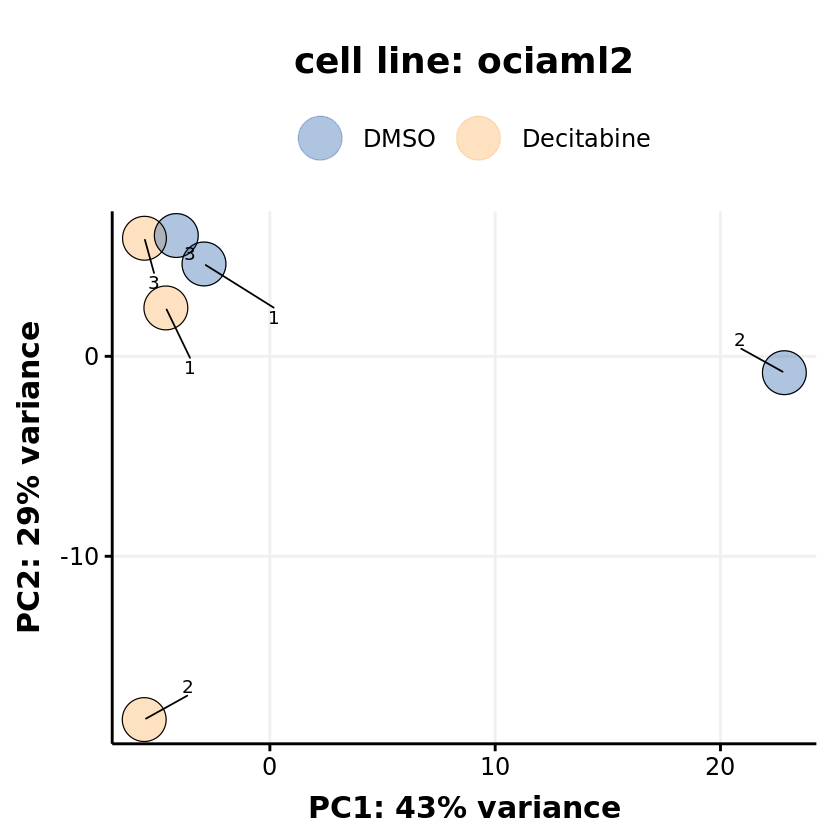

In [74]:
v = VSD[["ociaml2"]]
pca_ociaml2 <- plot_PCA(
    v,
    colData(v),
    labels = get_rep_id(colData(v)),
    title = 'cell line: ociaml2'
) 

ggsave('exp/plots/pca_ociaml2.pdf',pca_ociaml2,width=6, height=6.8)

pca_ociaml2

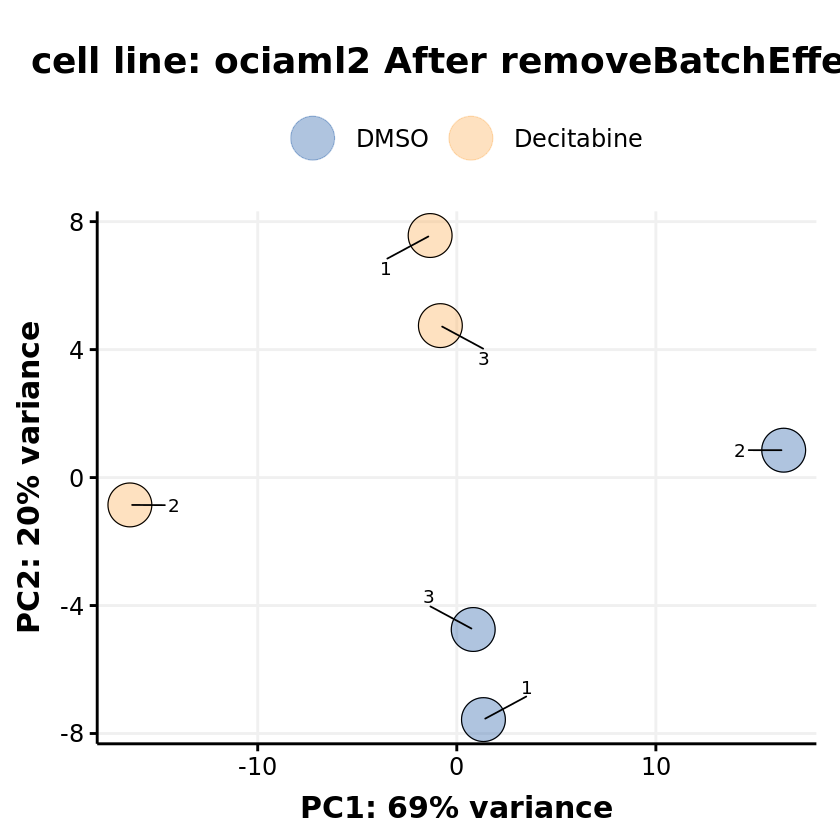

In [75]:
pca_ociaml2_corrected <- correct_batch(
    DDS1[['ociaml2']],c('cond'),'plot1',title='cell line: ociaml2',
    labels=get_rep_id(colData(DDS0[['ociaml2']]))
)

ggsave('exp/plots/pca_ociaml2_corrected.pdf',pca_ociaml2_corrected,width=6, height=6.8)

pca_ociaml2_corrected

#### `ociaml3` PCA analysis 

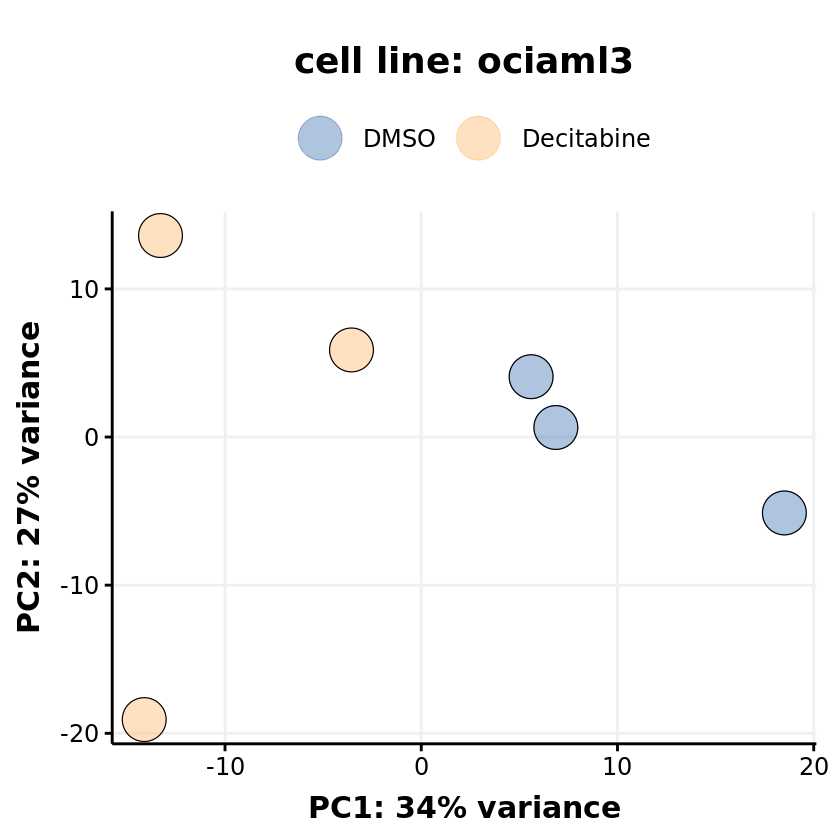

In [76]:
v = VSD[["ociaml3"]]
pca_ociaml3 <- plot_PCA(
    v ,
    colData(v),
    # labels = get_rep_id(colData(v)),
    title = 'cell line: ociaml3'
)

ggsave('exp/plots/pca_ociaml3.pdf',pca_ociaml3,width=6, height=6.8)

pca_ociaml3

### Differential expression analysis


Get results

In [77]:
DDS2 = list()
# RES2 = list()

# for loop to split DESeq object for more stable analysis  
for (l in unique(colData$line) ){
    if (l != 'hl60'){
        print (l)
        k = colData$line == l
        # cell lines with BatchEffect 
        if (l %in% c('thp1','ociaml2') ){
            # dds object for each cell line 
            dds_tmp1 <- DESeqDataSetFromTximport(txi.gene, colData, ~cond + reps)[,c(k)]
            DDS2[[l]]<- DESeq(dds_tmp1) #, parallel=TRUE)
            # rm(dds_tmp1)
        } 
        else {
            dds_tmp2 <- DESeqDataSetFromTximport(txi.gene, colData, ~cond)
            dds_tmp2 <- dds_tmp2[,c(k)] # subset samples from dds object https://www.biostars.org/p/442188/
            DDS2[[l]]<- DESeq(dds_tmp2) #, parallel=TRUE)
            # rm(dds_tmp2)
        }
        # get results 
        res = results(
            DDS2[[l]], 
            contrast=c('cond','Decitabine','DMSO'),
            parallel=TRUE
        ) %>% ann_Result

        RES[[l]] = res 
    }
}

[1] "kg1"


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "molm14"


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "ociaml2"


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "ociaml3"


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "thp1"


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



#### Check direction

In [78]:
RES[['thp1']] %>% arrange(desc(abs(log2FoldChange))) %>% head

,gene_id,gene_name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000286075.1,ENSG00000286075.1,AC009412.1,116.497579,-9.478572,3.055527,-3.102107,0.0019214864,0.1515380
ENSG00000262633.2,ENSG00000262633.2,AC005670.2,29.101225,6.334263,2.760239,2.294824,0.0217432248,0.5377946
ENSG00000137960.6,ENSG00000137960.6,GIPC2,6.551569,-6.228359,1.916612,-3.249671,0.0011553840,NA
ENSG00000198092.6,ENSG00000198092.6,TMPRSS11F,7.064768,6.039701,1.778621,3.395722,0.0006844792,NA
ENSG00000282907.1,ENSG00000282907.1,Z98883.1,12.128843,-5.933262,3.853238,-1.539812,0.1236061858,0.9574243
ENSG00000229932.3,ENSG00000229932.3,YWHAZP3,10.136249,5.893098,3.859241,1.527009,0.1267586644,NA


geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



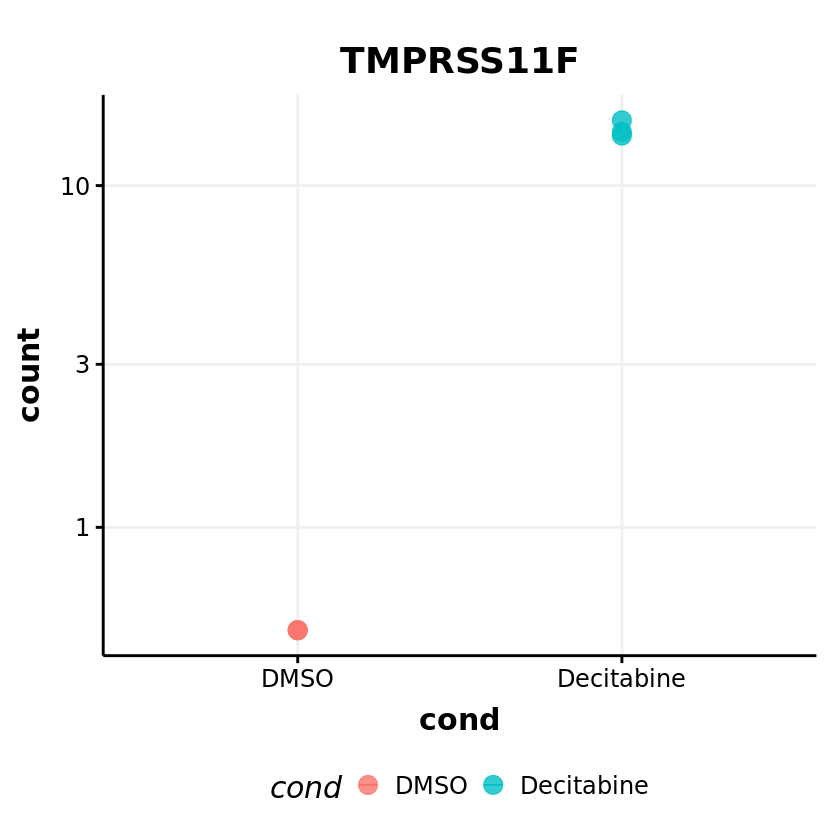

In [79]:
plot_gene_counts(DDS2[['thp1']],'ENSG00000198092.6','TMPRSS11F')

## Save results 

In [80]:
# temp file for running iPAGE 
for (name in names(RES)){
    print (name)
    # write results 
    RES[[name]] %>% 
        mutate(log2FoldChange = replace_na(log2FoldChange, 0)) %>% remove_rownames %>% 
        dplyr::select('gene_name','log2FoldChange') %>% 
        write_Result(paste('exp/',name,'_delta_exp.txt', sep=''),col=TRUE)
}

[1] "hl60_6h"
[1] "hl60_72h"
[1] "hl60_72h_only"
[1] "hl60_120h"
[1] "kg1"
[1] "molm14"
[1] "ociaml2"
[1] "ociaml3"
[1] "thp1"


In [81]:
for (name in names(RES)){
    print (name)
    # write results 
    RES[[name]] %>% 
        arrange(gene_name) %>% 
        dplyr::select('gene_id','gene_name','log2FoldChange','pvalue',everything()) %>% 
        write_Result(paste('exp/',name,'_delta_exp_table.txt', sep=''),col=TRUE)
}

[1] "hl60_6h"
[1] "hl60_72h"
[1] "hl60_72h_only"
[1] "hl60_120h"
[1] "kg1"
[1] "molm14"
[1] "ociaml2"
[1] "ociaml3"
[1] "thp1"


## Merge all fold change data 

In [82]:
result_table = data.frame(
    gene_name=gene2name[rownames(dds0),],
    gene_id=rownames(dds0)
)

In [83]:
for (name in names(RES)){
    print (name)
    
    df = RES[[name]] %>% select(c('log2FoldChange','pvalue')) 
    
    colnames(df) <- c(paste0(name,"_log2FC"),paste0(name,"_pvalue"))
    cbind(result_table,df%>% remove_rownames) -> result_table
}

[1] "hl60_6h"
[1] "hl60_72h"
[1] "hl60_72h_only"
[1] "hl60_120h"
[1] "kg1"
[1] "molm14"
[1] "ociaml2"
[1] "ociaml3"
[1] "thp1"


In [84]:
# write all results into one file 
write.table(
    result_table %>% column_to_rownames('gene_id'), 
    'exp/delta_exp_table.txt', quote = F, col.names=TRUE, row.names=TRUE,sep ='\t'
)

## Plots

### Correlation matrix

In [85]:
library(Hmisc)
library(corrplot)
library(pheatmap)
library(ggcorrplot)

Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following object is masked from ‘package:AnnotationDbi’:

    contents


The following object is masked from ‘package:Biobase’:

    contents


The following objects are masked from ‘package:base’:

    format.pval, units


corrplot 0.92 loaded



In [86]:
all_fc <- result_table %>% select(ends_with("log2FC")) 
colnames(all_fc) <- colnames(all_fc) %>% stringr::str_remove(pattern = "_log2FC") %>% unlist


In [87]:
corr <- rcorr(
    as.matrix(
        all_fc %>% select('hl60_6h','hl60_72h','hl60_120h','kg1','molm14','ociaml2','ociaml3','thp1')
    )
)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



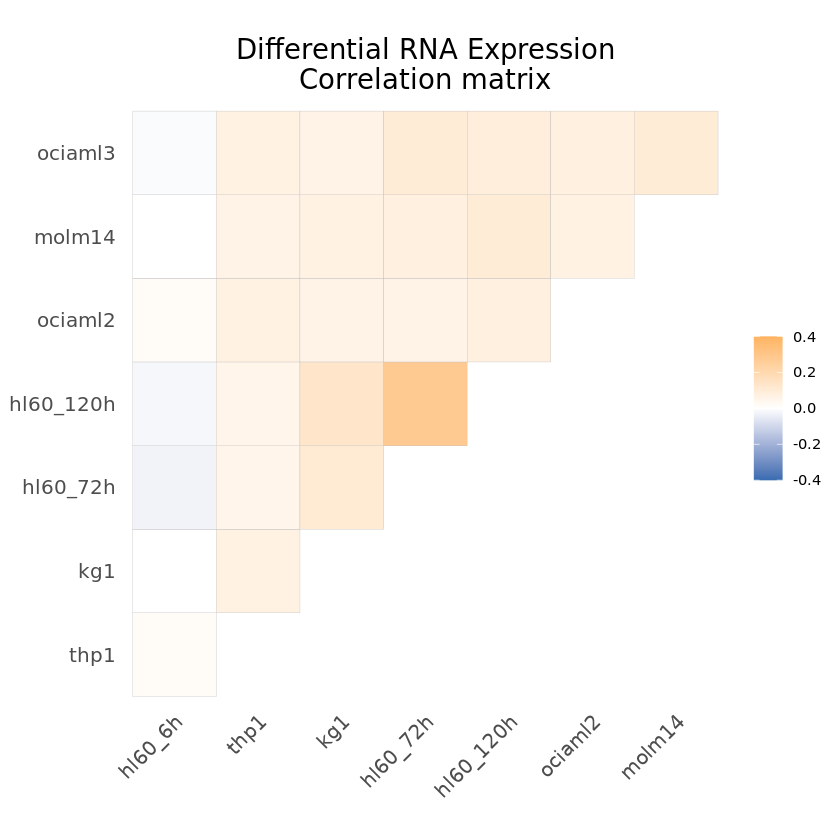

In [88]:
colors=c("#386cb0","white","#fdb462")
ggcorrplot(
    corr$r, 
    method = c("square", "circle"),
    hc.order = TRUE,type = "upper", 
    p.mat = corr$p,
    
) + ggtitle(
    "Differential RNA Expression\nCorrelation matrix"
) + ggplot2::scale_fill_gradient2(
    low = colors[1], high = colors[3], mid = colors[2], 
    midpoint = 0, limit = c(-0.4, 0.4), space = "Lab"
) + theme(
    plot.title = element_text(
        # face = "bold",
        size = rel(1.5), hjust = 0.5),
    panel.background = element_blank(), 
    panel.border = element_blank(), 
    panel.grid.major = element_line(colour = "white"), 
    legend.title = element_blank(),
    # legend.position="bottom"
)

ggsave('exp/plots/logFC_corr.pdf',width = 4, height = 4)

### Volcano plots

In [263]:
plot_Volcano <- function (res, lfc.cutoff, pval.cutoff, title, labels, x_min, x_max) {
    
    colors_values = c("grey80", "tan")

    vol <- res %>% ggplot(aes(x = log2FoldChange, y = -log10(pvalue))) + 
        geom_point(
            data = res %>% filter(
                abs(log2FoldChange) >= lfc.cutoff, 
                pvalue < pval.cutoff), 
            aes(x = log2FoldChange, y = -log10(pvalue)), 
            size = 3, alpha = 5/10, shape = 21, 
            color = colors_values[2],
            fill = colors_values[2]) + 

        geom_point(
            data = res %>% filter(
                (abs(log2FoldChange) < lfc.cutoff) | 
                (pvalue >= pval.cutoff)), 
            aes(x = log2FoldChange, y = -log10(pvalue)), 
            size = 1, alpha = 5/10, shape = 21, color = colors_values[1], 
            fill = colors_values[1]) + 

        geom_point(
            data = res %>% filter(gene_name %in% labels),
            aes(x = log2FoldChange, y = -log10(pvalue)), 
            shape = 21, size = 3, color = "grey40", fill = "red3") + 
        
        geom_rug(
            data = res %>% filter(
                abs(log2FoldChange) >= lfc.cutoff, 
                pvalue < pval.cutoff), 
            sides = "b", colour='tan') + 

        geom_label_repel(
            data = res %>% filter(gene_name %in% labels), 
            aes(label = gene_name), box.padding = 1, max.overlaps = Inf) + 

        xlim(c(x_min, x_max)) + 
        ylim(c(0, -log10(res %>% select(pvalue) %>% min ))) + 
        geom_hline(yintercept = -log10(pval.cutoff), linetype = "dashed", alpha = 5/10) + 
        geom_text(aes(
            x_min*0.9,-log10(pval.cutoff),
            label = paste("-~log[10]~(",pval.cutoff,')',sep=''), 
            vjust = x_min*0.05
        ),parse = TRUE) +

        theme(
            legend.position = "none"
        ) + 
        ggtitle(title) + theme_Publication()

    return(vol)
}

In [90]:
VOL = list()

In [209]:
target_genes = c(
    'SQLE','INTS5'
)
m6A_genes = c(
    # RNA m6A methylation genes 
    'METTL3','METTL14','WTAP','KIAA1429','RBM15','RBM15B','METTL16',
    'FTO','ALKBH5',
    'YTHDC1','YTHDF1','YTHDF2','YTHDF3','HNRNPA2B1','EIF3','HNRNPC'
)
dnmt_genes <- c(
    ## KEGG_CYSTEINE_AND_METHIONINE_METABOLISM
    ## Cysteine and methionine metabolism
    'ADI1','AHCY','AHCYL1','AHCYL2','AMD1','APIP','BHMT','CBS','CDO1','CTH',
    'DNMT1','DNMT3A','DNMT3B','DNMT3L','ENOPH1','GOT1','GOT2','IL4I1','LDHA',
    'LDHAL6A','LDHAL6B','LDHB','LDHC','MAT1A','MAT2A','MAT2B','MPST','MTAP','MTR',
    'SDS','SMS','SRM','TAT','TRDMT1'
)

## GOBP_TRNA_WOBBLE_BASE_MODIFICATION
## The process in which the nucleotide at position 34 in 
## the anticodon of a tRNA is post-transcriptionally modified. 
## [GOC:hjd, ISBN:155581073X]
tRNA_wobble <- c(
    'ADAT2','ALKBH1','ALKBH8','CTU1','CTU2','DPH3','DPH3P1',
    'ELP1','ELP2','ELP3','ELP4','ELP5','ELP6','GTPBP3','KTI12',
    'MOCS3','MTO1','NSUN3','TRMT9B','TRMU','URM1'
)

labels = c(m6A_genes, target_genes,dnmt_genes,tRNA_wobble)

In [132]:
names(RES)

[1] "hl60_6h"       "hl60_72h"      "hl60_72h_only" "hl60_120h"    
[5] "kg1"           "molm14"        "ociaml2"       "ociaml3"      
[9] "thp1"

#### hl60 time series

In [264]:
### genes from my intersectional-analysis of iPAGE results across hl60 comparisons 
hl60_label_genes = c(
    'MAEL',
    'PIWIL2',
    'TDRD1'
)

In [265]:
VOL[['hl60_6h']] = plot_Volcano(
    RES[['hl60_6h']] %>% drop_na(),
    lfc.cutoff  = 0, 
    pval.cutoff = 0.01,
    title  = '6 hours treatment',
    # labels = c(hl60_label_genes,target_genes), 
    labels = target_genes, 
    x_min = -15, x_max = 15
)

In [266]:
VOL[['hl60_72h']] = plot_Volcano(
    RES[['hl60_72h']] %>% drop_na(),
    lfc.cutoff  = 0, 
    pval.cutoff = 0.01,
    title  = '72 hours treatment', 
    # labels = c(hl60_label_genes,target_genes), 
    labels = target_genes, 
    x_min = -15, x_max = 15
)

In [267]:
VOL[['hl60_120h']] <- plot_Volcano(
    RES[['hl60_120h']] %>% drop_na(),
    lfc.cutoff  = 0, 
    pval.cutoff = 0.01,
    title  = '120 hours treatment', 
    # labels = c(hl60_label_genes,target_genes), 
    labels = target_genes, 
    x_min = -15, x_max = 15
)

In [268]:
hl60_vol <- VOL[['hl60_6h']] / VOL[['hl60_72h']] / VOL[['hl60_120h']]

# Remove title from first subplot
hl60_vol[[1]] = hl60_vol[[1]] + theme(axis.text.x = element_blank(),
                                        axis.ticks.x = element_blank(),
                                        axis.title.x = element_blank() )

# Remove title from second subplot
hl60_vol[[2]] = hl60_vol[[2]] + theme(axis.text.x = element_blank(),
                                        axis.ticks.x = element_blank(),
                                        axis.title.x = element_blank() )

In [269]:
# hl60_vol

In [270]:
ggsave(
    'exp/plots/volcano_hl60.pdf', 
    plot = hl60_vol, device = 'pdf', width = 8, height=15
    #, dpi = 300
)

Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”


In [271]:
ggsave(
    'exp/plots/volcano_hl60.png', 
    plot = hl60_vol, device = 'png', width = 8, height=15, dpi = 300
)

Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”


#### 72h trearment in all cell lines 

In [133]:
lfc.cutoff = 1
pval.cutoff = 0.05
x_min = -8
x_max = 8


VOL[['hl60_72h_only']] = plot_Volcano(
    RES[['hl60_72h_only']] %>% drop_na(),
    lfc.cutoff, pval.cutoff, 
    title  = 'HL60',
    labels, x_min, x_max
)

VOL[['kg1']] = plot_Volcano(
    RES[['kg1']] %>% drop_na(),
    lfc.cutoff, pval.cutoff,
    title  = 'KG-1',
    labels, x_min, x_max
)

VOL[['molm14']] = plot_Volcano(
    RES[['molm14']] %>% drop_na(),
    lfc.cutoff, pval.cutoff,
    title  = 'MOLM-14', 
    labels, x_min, x_max
)


VOL[['ociaml2']] = plot_Volcano(
    RES[['ociaml2']] %>% drop_na(),
    lfc.cutoff, pval.cutoff, 
    title  = 'OCIAML2',
    labels, x_min, x_max
)

VOL[['ociaml3']] <- plot_Volcano(
    RES[['ociaml3']] %>% drop_na(),
    lfc.cutoff, pval.cutoff,
    title  = 'OCIAML3', 
    labels, x_min, x_max
)

VOL[['thp1']] <- plot_Volcano(
    RES[['thp1']] %>% drop_na(),
    lfc.cutoff, pval.cutoff,
    title  = 'THP-1', 
    labels, x_min, x_max
)

In [95]:
# pdf('exp/plots/volcano_plots.pdf')
for (name in  names(VOL)){
    # print (VOL[[name]])    
    ggsave(
        paste0('exp/plots/volcano_',name,'.pdf'), 
        plot = VOL[[name]], device = 'pdf', width = 5, height=5, dpi = 300
    )
}
# dev.off()

Warning message:
“Removed 12 rows containing missing values (geom_point).”
Warning message:
“Removed 35 rows containing missing values (geom_point).”
Warning message:
“Removed 48 rows containing missing values (geom_point).”
Warning message:
“Removed 17 rows containing missing values (geom_point).”
Warning message:
“Removed 28 rows containing missing values (geom_point).”
Warning message:
“Removed 9 rows containing missing values (geom_point).”
Warning message:
“Removed 49 rows containing missing values (geom_point).”
Warning message:
“Removed 14 rows containing missing values (geom_point).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


### Clustering 

In [96]:
# mostVar <- function(data, n, i_want_most_var = TRUE) {
#   data.var <- apply(data, 1, stats::var)
#   data[order(data.var, decreasing = i_want_most_var)[1:n],] 
# }

In [97]:
library(pheatmap)
library(RColorBrewer)

heat_colors <- brewer.pal(n = 6, name = "RdYlBu") %>% rev
greens <- brewer.pal(n = 9, name = "Greens")

### Heatmap to show HL-60 time series clusters

In [98]:
ann_colors = list(
    cond = c('DMSO'="grey90", 'Decitabine'="darkorchid"),
    time = c('120h'= greens[6], '72h'=greens[4], '6h'=greens[2])
)

png 
  2

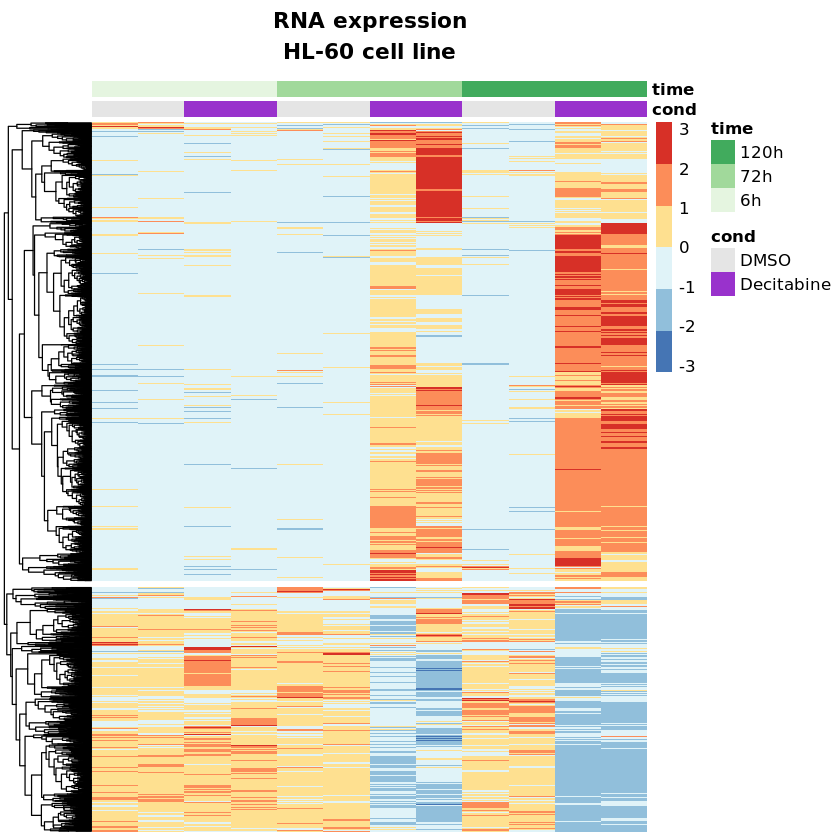

In [99]:
ncu[
    # select genes based on abs(log2FC) and pvalue
    result_table %>%
        filter(
            (abs(hl60_6h_log2FC)  > 1 & hl60_6h_pvalue   < 0.01) |
            (abs(hl60_72h_log2FC) > 1 & hl60_72h_pvalue  < 0.01)|
            (abs(hl60_120h_log2FC)> 1 & hl60_120h_pvalue < 0.01) 
        ) %>% column_to_rownames('gene_id') %>% rownames
    ,
    # subset normalized counts
    colData[colData$line=='hl60',c('cond','time')] %>% arrange(time,cond) %>% rownames
] %>% 
    # generate heatmap
    pheatmap(
        color = heat_colors, 
        show_colnames = F,
        show_rownames = F,
        cutree_rows = 2,
        main = 'RNA expression\nHL-60 cell line',
        annotation = colData[colData$line=='hl60',c('cond','time')],
        cluster_cols = F, 
        scale = 'row',
        angle_col= 45,
        annotation_colors = ann_colors
) -> hm_hl60

# https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
pdf('exp/plots/heatmap_clustering_hl60.pdf', width=4, height=7)
grid::grid.newpage()
grid::grid.draw(hm_hl60$gtable)
dev.off()

#### Target genes

In [ ]:
# labels = c(m6A_genes, target_genes,dnmt_genes)

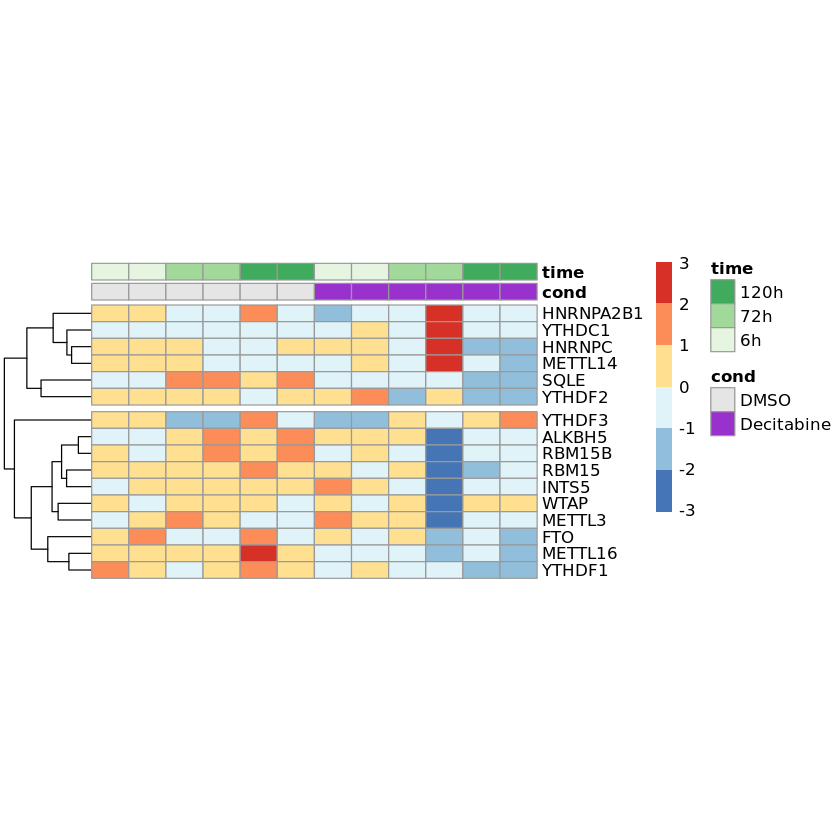

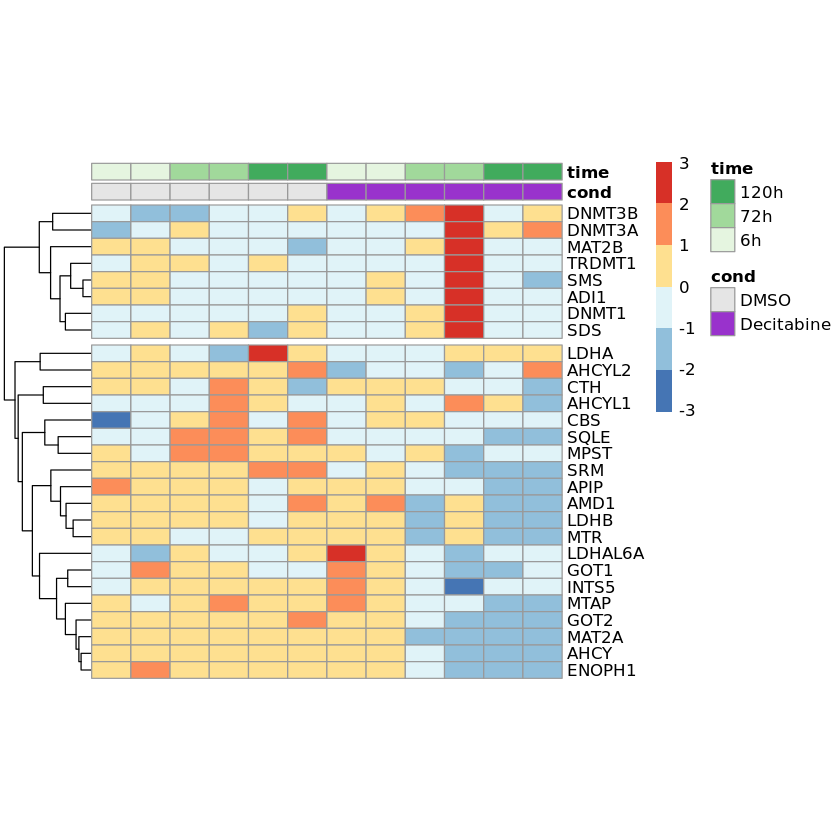

In [128]:
ann_colors = list(
    cond = c('DMSO'="grey90", 'Decitabine'="darkorchid"),
    time = c('120h'= greens[6], '72h'=greens[4], '6h'=greens[2])
)

for (
    genes in list(
        c(m6A_genes, target_genes),
        c(dnmt_genes, target_genes)
    )){
    mat <- ncu[
        # subset to selected genes 
        ncu$name %in% genes,#labels, 
        # subset normalized counts
        c('name',colData[colData$line=='hl60',c('cond','time')] %>% arrange(cond,time) %>% rownames)
    ] %>%  remove_rownames %>% column_to_rownames('name') 

    mat[rowSums(mat > 10) > 0,] %>% 
    # tibble::rownames_to_column() %>%    
    # pivot_longer(-rowname) %>%    
    # pivot_wider(names_from=rowname, values_from=value)  %>% 
    # summary
        # generate heatmap
        pheatmap(
            color = heat_colors, 
            show_colnames = F,
            # show_rownames = F,
            cutree_rows = 2,
            # main = 'RNA expression\nHL-60 cell line\nm6A genes',
            annotation = colData[colData$line=='hl60',c('cond','time')],
            cluster_rows = T, 
            cluster_cols = F, 
            scale = 'row',
            cellheight=10,
            angle_col= 45,
            annotation_colors = ann_colors
    )
    # -> hm_hl60_labels
}

    # # # https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
    # # pdf('exp/plots/heatmap_clustering_hl60_target_genes.pdf', width=4, height=4)
    # # grid::grid.newpage()
    # # grid::grid.draw(hm_hl60_labels$gtable)
    # # dev.off()

### Heatmap to show cell line consistency 

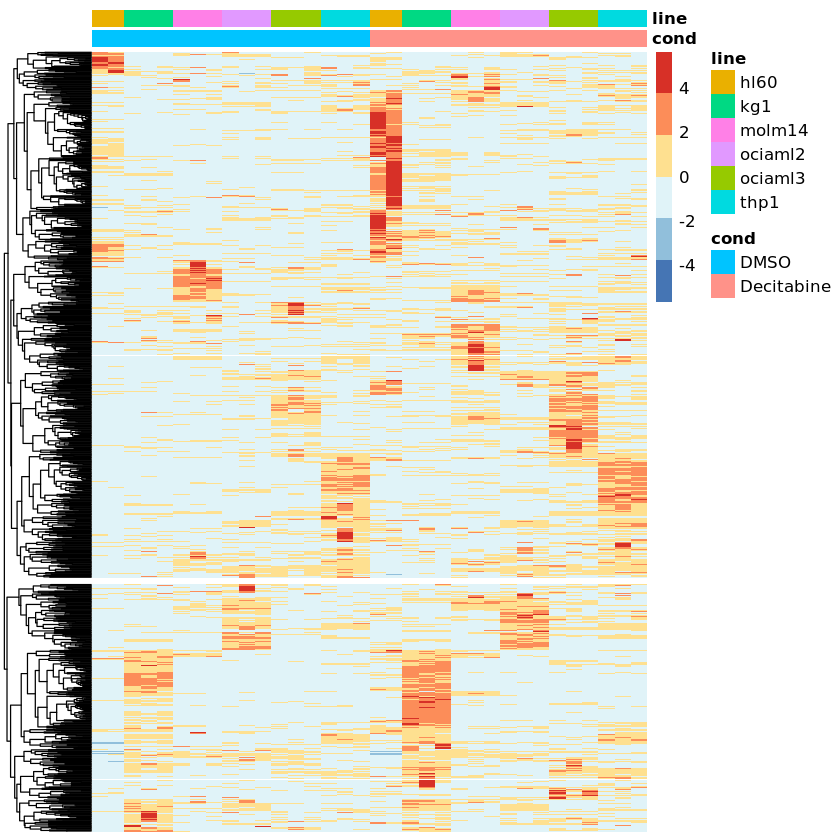

In [101]:
# ann_colors = list(
#     cond = c('DMSO'="grey90", 'Decitabine'="darkorchid"),
#     time = c('120h'= greens[6], '72h'=greens[4], '6h'=greens[2])
# )

ncu[
    # select genes based on abs(log2FC) and pvalue
    result_table %>%
        filter(
            # (abs(hl60_72h_log2FC)  > 1 & hl60_72h_pvalue   < 0.01)     &
            (abs(hl60_72h_only_log2FC)  > 2 & hl60_72h_only_pvalue   < 0.01)     |
            (abs(kg1_log2FC)    > 2 & kg1_pvalue   < 0.01)    |
            (abs(molm14_log2FC) > 2 & molm14_pvalue  < 0.01)  |
            (abs(ociaml2_log2FC)> 2 & ociaml2_pvalue < 0.01)  |
            (abs(ociaml3_log2FC)> 2 & ociaml3_pvalue < 0.01)  |
            (abs(thp1_log2FC)   > 2 & thp1_pvalue   < 0.01) 
        ) %>% column_to_rownames('gene_id') %>% rownames
    , 
    # arrange it!
    colData[colData$time=='72h',c('cond','time')] %>% arrange(time,cond) %>% rownames
] %>%  
    # # subset actual normalized counts
    # select(starts_with('hl60')) %>%
    # generate heatmap
    pheatmap(
        color = heat_colors, 
        show_colnames = F,
        show_rownames = F,
        cutree_rows = 2,
        # main = 'RNA expression\nHL-60 cell line',
        annotation = colData[colData$time=='72h',] %>% arrange(time,cond) %>% select(c('cond','line')),
        cluster_cols = F, 
        scale = 'row',
        # angle_col= 45,
        # annotation_colors = ann_colors
) 
# -> hm_hl60

# # https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
# pdf('exp/plots/heatmap_clustering_hl60.pdf', width=4, height=7)
# grid::grid.newpage()
# grid::grid.draw(hm_hl60$gtable)
# dev.off()

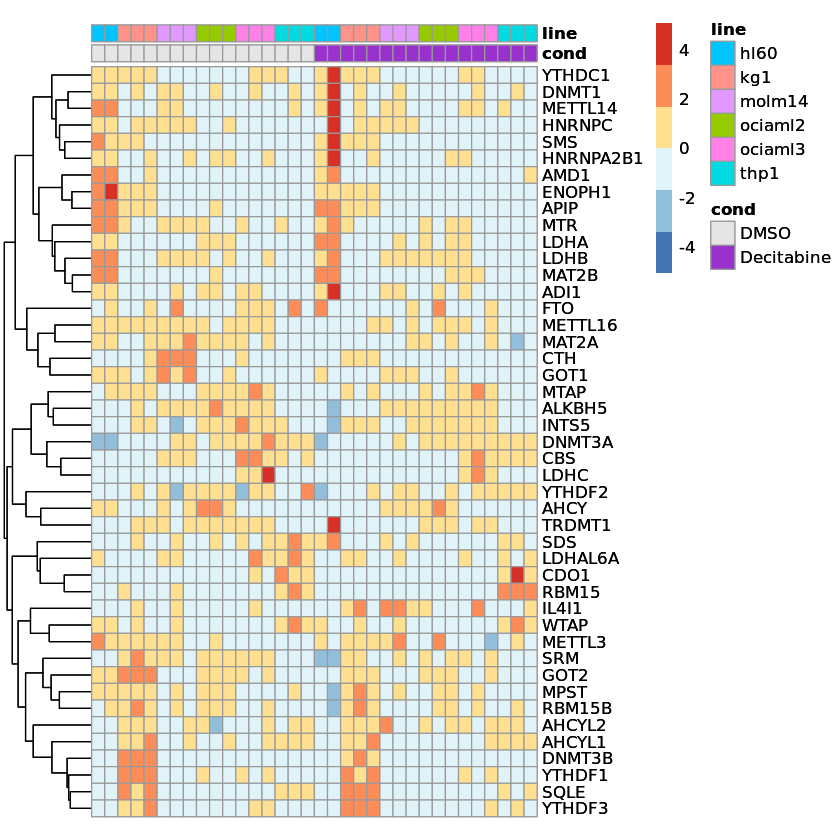

In [112]:
# ann_colors = list(
#     cond = c('DMSO'="grey90", 'Decitabine'="darkorchid"),
#     time = c('120h'= greens[6], '72h'=greens[4], '6h'=greens[2])
# )

mat <- ncu[
    # subset to selected genes 
    ncu$name %in% labels
    , 
    # subset normalized counts
    
] %>%  remove_rownames %>% column_to_rownames('name') %>% 
select(colData[colData$time=='72h',c('cond','line')] %>% arrange(cond,line) %>% rownames)

mat[rowSums(mat > 10) > 0,] %>% 
# tibble::rownames_to_column() %>%    
# pivot_longer(-rowname) %>%    
# pivot_wider(names_from=rowname, values_from=value)  %>% 
# summary
    # generate heatmap
    pheatmap(
        color = heat_colors, 
        show_colnames = F,
        # show_rownames = F,
        # cutree_rows = 2,
        # main = 'RNA expression\nHL-60 cell line',
        annotation = colData[colData$time=='72h',c('cond','line')] %>% arrange(cond,line),
        cluster_rows = T, 
        cluster_cols = F, 
        scale = 'row',
        cellheight=10,
        angle_col= 45,
        annotation_colors = ann_colors
) -> hm_all_cell_lines_labels
hm_all_cell_lines_labels

# # # https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
# # pdf('exp/plots/heatmap_clustering_hl60_target_genes.pdf', width=4, height=4)
# # grid::grid.newpage()
# # grid::grid.draw(hm_hl60_labels$gtable)
# # dev.off()

In [184]:
# ann_colors = list(
#     cond = c('DMSO'="grey90", 'Decitabine'="darkorchid"),
#     time = c('120h'= greens[6], '72h'=greens[4], '6h'=greens[2])
# )

# ncu[
#     # subset to selected genes 
#     ncu$name %in% labels, 
#     # subset normalized counts
#     colData[colData$time=='72h',c('cond','time')] %>% arrange(time,cond) %>% rownames
# ] %>% remove_rownames %>% column_to_rownames('name') %>% head
# #     # generate heatmap
# #     pheatmap(
# #         color = heat_colors, 
# #         show_colnames = F,
# #         # show_rownames = F,
# #         # cutree_rows = 2,
# #         main = 'RNA expression\nHL-60 cell line',
# #         annotation = colData[colData$line=='hl60',c('cond','time')],
# #         cluster_rows = T, 
# #         cluster_cols = F, 
# #         scale = 'row',
# #         cellheight=20,
# #         angle_col= 45,
# #         annotation_colors = ann_colors
# # ) -> hm_hl60_labels

# # # https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
# # pdf('exp/plots/heatmap_clustering_hl60_target_genes.pdf', width=4, height=4)
# # grid::grid.newpage()
# # grid::grid.draw(hm_hl60_labels$gtable)
# # dev.off()

# Session Info

In [1]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data_gilbert/home/aarab/anaconda3/envs/deseq2/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] fansi_0.4.2     digest_0.6.28   utf8_1.2.2      crayon_1.4.2   
 [5] IRdisplay_1.0   repr_1.1.3      lifecycle_1.0.1 jsonlite_1.7.2 
 [9] evaluate_0.14   pillar_1.6.4    rlang_0.4.12    uuid_1.0-3     
[13] vctrs_0.3.8     ellipsis_0.3.2  IRkernel_1.2    tools_4.1.1 

In [10]:
date()

[1] "Fri Dec 10 12:33:08 2021"